<a href="https://colab.research.google.com/github/IvanGonzal0/Proyecto3_BigData_Clustering/blob/main/Proyecto3_BigData_IvanGonzaloTapia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laboratorio 3 Machine Learning**


## *Clasificador zonas según el peligro*
## `Introducción`

En el laboratorio, nos centraremos en un conjunto de datos que incluye registros de
crímenes de 1973 en distintos estados de EE. UU., así como el porcentaje de la población
que reside en zonas urbanas en esos estados. El propósito es clasificar los estados en
diferentes categorías basadas en estos factores.
## `Conjunto de datos`

Crímenes
● Asesinatos: La tasa de asesinatos, que se suele calcular como el número de
asesinatos por cada 100,000 habitantes en el estado.
● Asaltos: La tasa de asaltos, que también se calcula por cada 100,000 habitantes.
Esto incluiría casos de ataques violentos, incluyendo agresiones físicas.
● Población Urbana: El porcentaje de la población que vive en áreas urbanas del
estado. Un número más alto indica una mayor concentración de población en las
ciudades.
● Violaciónes: La tasa de violaciones, similarmente calculada por cada 100,000
habitantes. Representa la incidencia de este tipo de crimen en el estado
## `Tarea a desarrollar`

Se debe desarrollar un programa que permita clasificar los estados en diferentes categorías,
dividiéndolos en zonas de baja peligrosidad y alta peligrosidad. Este proyecto debe ser
ejecutado en un Notebook de Colab.
No es necesario aplicar múltiples modelos de clustering, ¡con aplicar uno de ellos está más
que bien!
Dentro del Notebook, es importante que cada paso del proceso esté acompañado por
bloques de texto que expliquen el razonamiento detrás de las decisiones tomadas. Se debe
detallar por qué se eligieron ciertas técnicas, métodos o parámetros y cuál es su relevancia
en el contexto del proyecto. Además, es necesario documentar los desafíos o
inconvenientes que surgieron durante el desarrollo, proporcionando una visión clara y
completa del proceso de diseño e implementación de la solución.


### 1 - Importación de librerias, carga y preprocesamiento de datos. Utilizando `Pandas NumPy SKLearn`

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift, DBSCAN

In [118]:
path = '/content/drive/MyDrive/UPSO ML & BD/DatasetClustering/Crimenes.csv'

In [119]:
df = pd.read_csv(path)   #cargar el archivo csv en un df
df_crimenes = df.copy()  #copia del df original
df_crimenes.head()

Estado  Asesinatos  Asaltos  Poblacion Urbana  Violaciones
0     Alabama        13.2      236                58         21.2
1      Alaska        10.0      263                48         44.5
2     Arizona         8.1      294                80         31.0
3    Arkansas         8.8      190                50         19.5
4  California         9.0      276                91         40.6

In [120]:
X = df[['Asesinatos', 'Asaltos', 'Poblacion Urbana', 'Violaciones']]

### 2 - Visualizacion de datos con `Matplotlib y Seaborn`

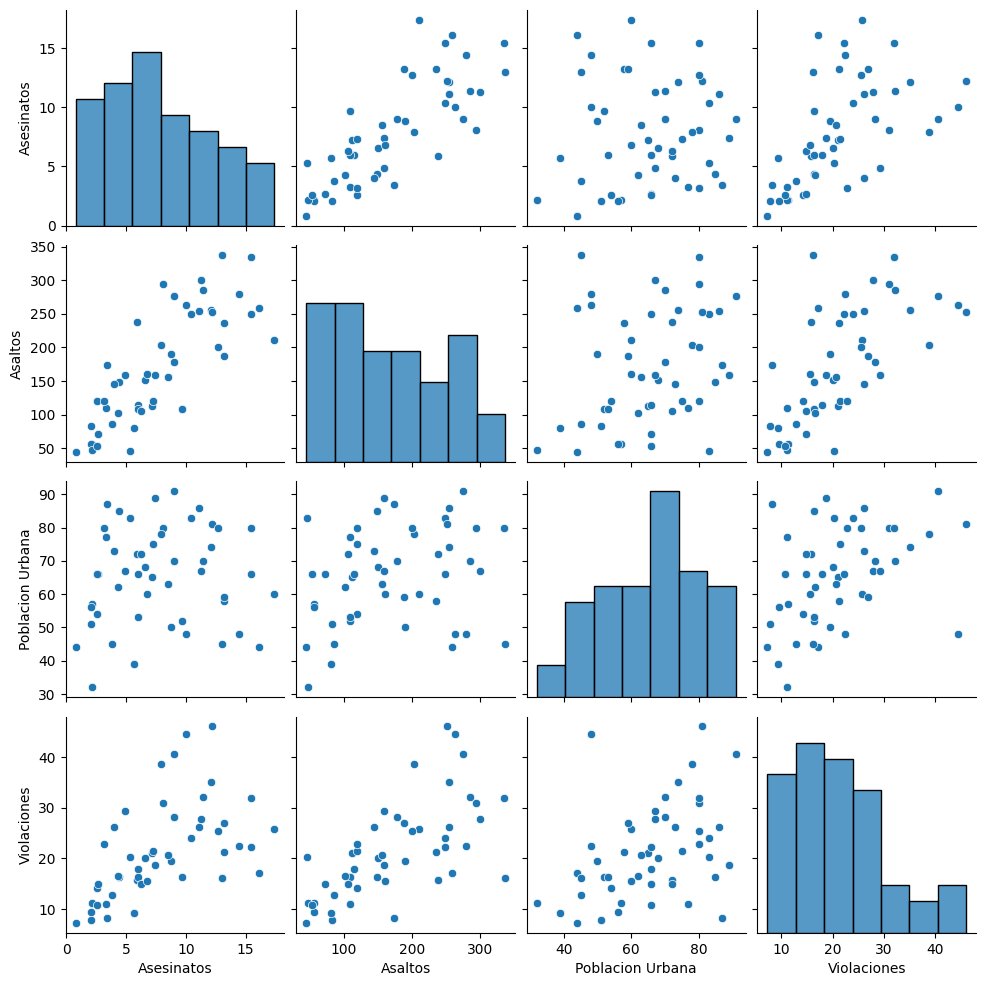

In [14]:
sns.pairplot(X)
plt.show()

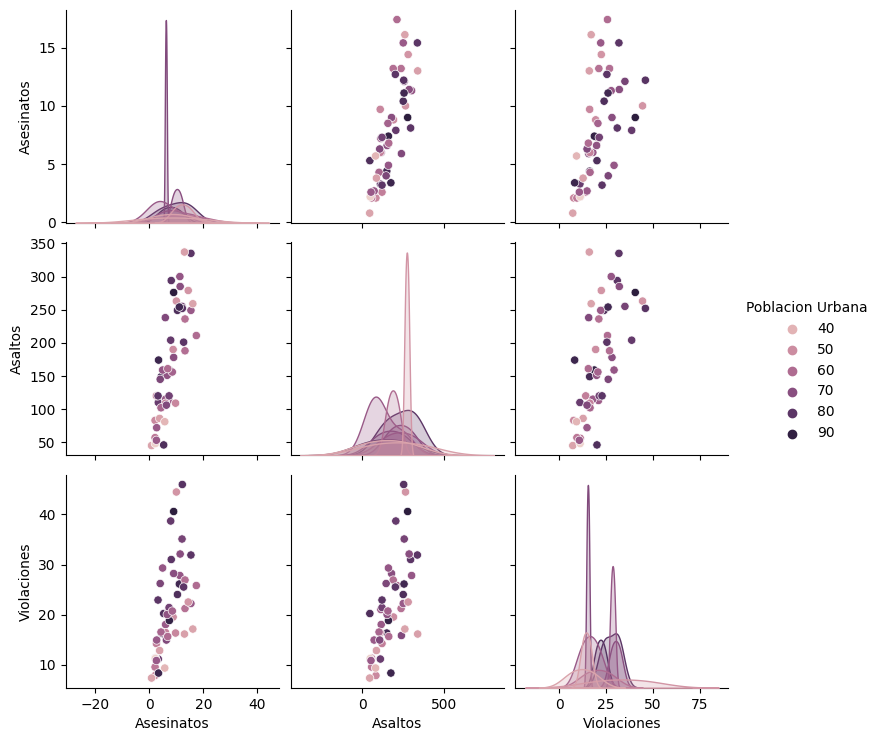

In [13]:
sns.pairplot(X, hue='Poblacion Urbana')
plt.show()

### 3 - Creación de Modelo `KMeans de SKLearn`

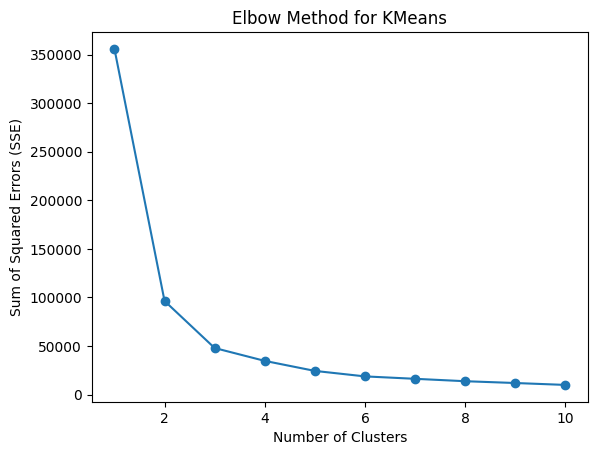

In [121]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_optimal_clusters_kmeans(data, max_k):
    sse = [] # Sum of squared errors
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, n_init=max_k).fit(data)
        sse.append(kmeans.inertia_)

    plt.plot(range(1, max_k+1), sse, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.title("Elbow Method for KMeans")
    plt.show()

# Ejemplo:
find_optimal_clusters_kmeans(X, 10)

In [122]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [123]:

df_crimenes['clusters'] = clusters
df_crimenes.head()

Estado  Asesinatos  Asaltos  Poblacion Urbana  Violaciones  clusters
0     Alabama        13.2      236                58         21.2         2
1      Alaska        10.0      263                48         44.5         2
2     Arizona         8.1      294                80         31.0         2
3    Arkansas         8.8      190                50         19.5         0
4  California         9.0      276                91         40.6         2

In [125]:
etiquetas = {0: 'Precaucion', 1: 'Seguro', 2: 'Peligroso'}

df_crimenes['Nivel_Seguridad'] = df_crimenes['clusters'].map(etiquetas)
df_crimenes = df_crimenes.drop('clusters', axis=1)
df_crimenes.head()

Estado  Asesinatos  Asaltos  Poblacion Urbana  Violaciones  \
0     Alabama        13.2      236                58         21.2   
1      Alaska        10.0      263                48         44.5   
2     Arizona         8.1      294                80         31.0   
3    Arkansas         8.8      190                50         19.5   
4  California         9.0      276                91         40.6   

  Nivel_Seguridad  
0       Peligroso  
1       Peligroso  
2       Peligroso  
3      Precaucion  
4       Peligroso

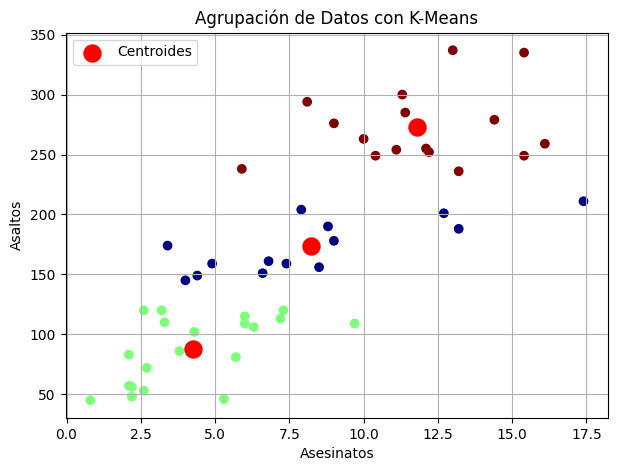

In [126]:
plt.figure(figsize=(7, 5))
plt.scatter(X['Asesinatos'], X['Asaltos'], c = clusters, cmap = 'jet')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 150, c = 'red', marker = 'o', label = 'Centroides')

plt.xlabel('Asesinatos')
plt.ylabel('Asaltos')
plt.title('Agrupación de Datos con K-Means')
plt.grid(True)
plt.legend()
plt.show()

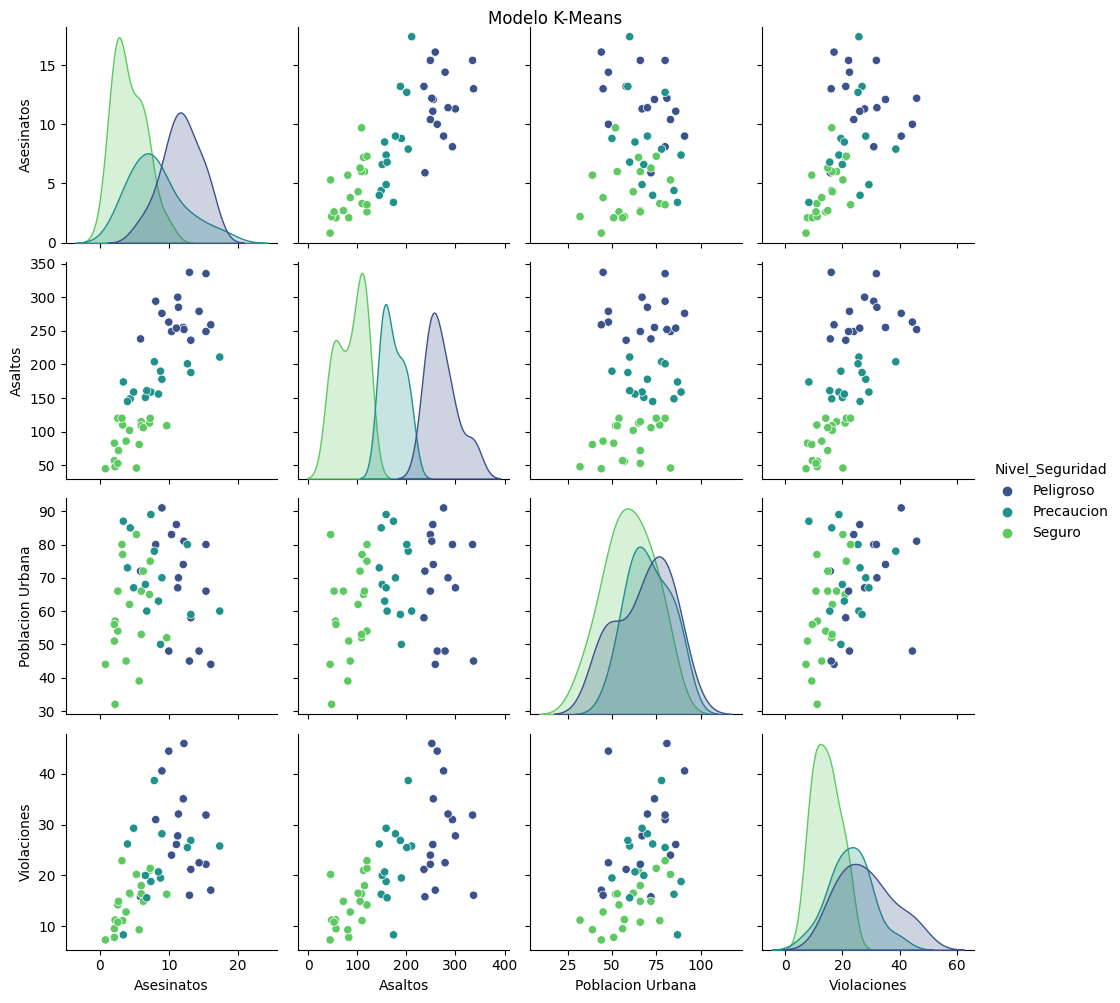

In [128]:
sns.pairplot(df_crimenes, hue='Nivel_Seguridad', palette='viridis')
plt.suptitle('Modelo K-Means', y=1)
plt.show()

### 4 - Creación de Modelo `Mean Shift de SKLearn`

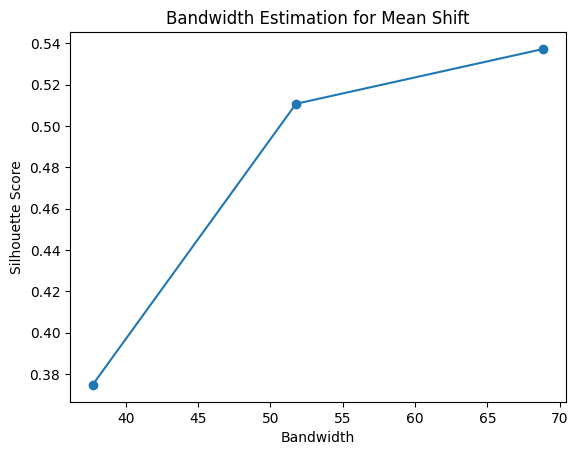

In [130]:
from sklearn.cluster import estimate_bandwidth

def estimate_bandwidth_meanshift(data, quantile_range=(0.2, 0.5), step=0.1):
    bandwidths = []
    silhouettes = []

    quantiles = np.arange(quantile_range[0], quantile_range[1], step)

    for quantile in quantiles:
        bandwidth = estimate_bandwidth(data, quantile=quantile)
        bandwidths.append(bandwidth)

        ms = MeanShift(bandwidth=bandwidth).fit(data)
        if len(np.unique(ms.labels_)) > 1:
            sil_score = silhouette_score(data, ms.labels_)
            silhouettes.append(sil_score)
        else:
            silhouettes.append(-1)

    plt.plot(bandwidths, silhouettes, 'o-')
    plt.xlabel("Bandwidth")
    plt.ylabel("Silhouette Score")
    plt.title("Bandwidth Estimation for Mean Shift")
    plt.show()

estimate_bandwidth_meanshift(X)

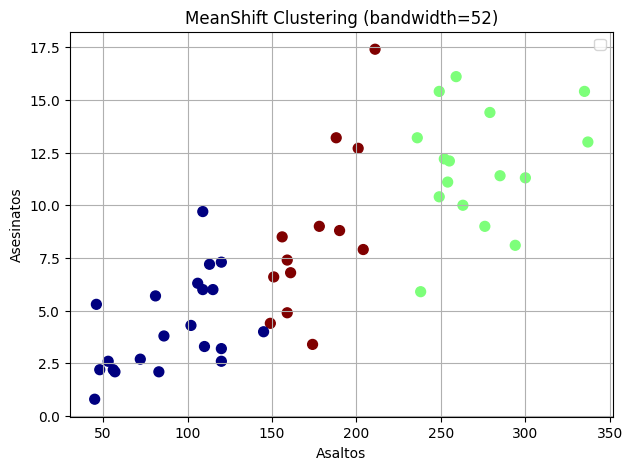

In [140]:
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

# Aplicar MeanShift con bandwidth=1.6
bandwidth =52
ms = MeanShift(bandwidth=bandwidth).fit(X)
labels = ms.labels_

# Graficar los resultados
plt.figure(figsize=(7, 5))
plt.scatter(X['Asaltos'], X['Asesinatos'], c=labels, s=50, cmap='jet')
# plt.scatter(ms.cluster_centers_[:, 0], ms.cluster_centers_[:, 1], s=200, c='red', marker='X', label="Centroids")
plt.title(f'MeanShift Clustering (bandwidth={bandwidth})')
plt.xlabel("Asaltos")
plt.ylabel("Asesinatos")
plt.legend()
plt.grid(True)
plt.show()

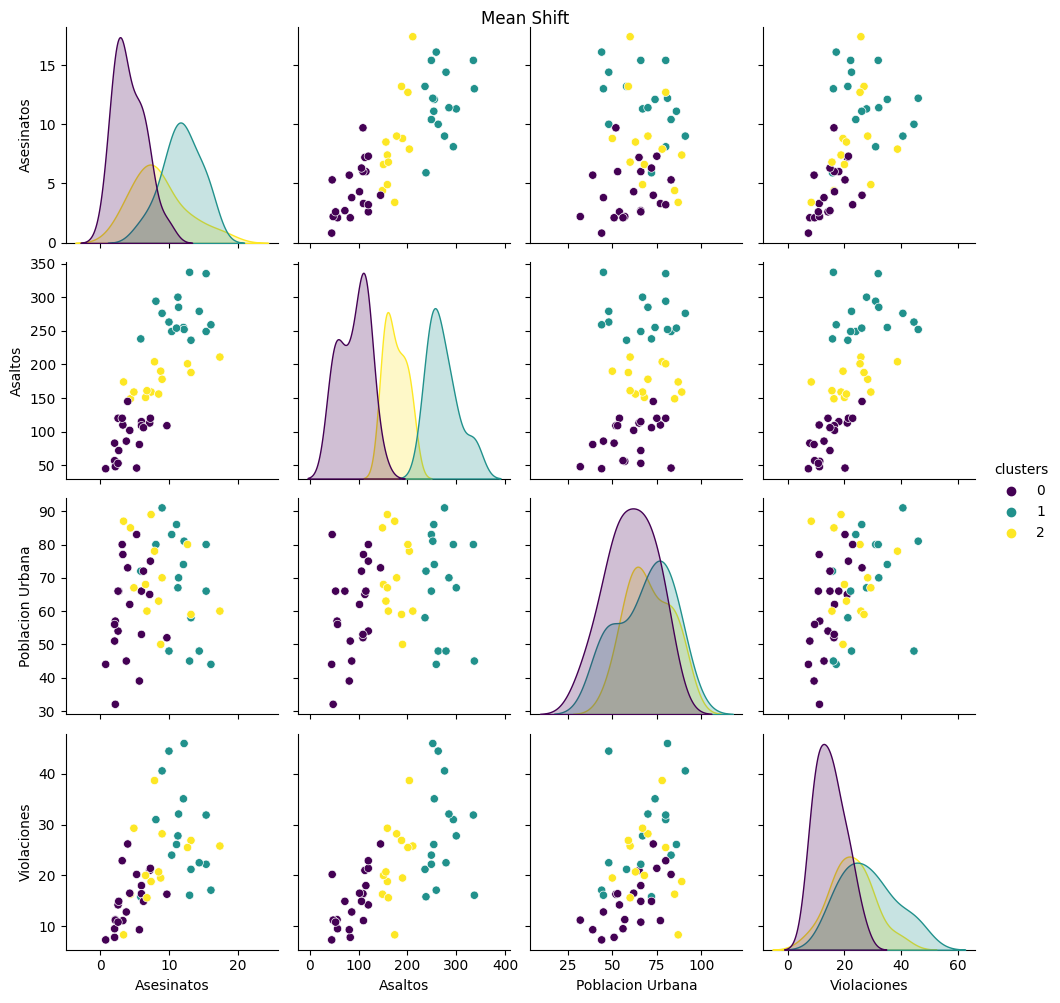

In [143]:
df_crimenes_ms = X.copy()

df_crimenes_ms["clusters"] = labels

sns.pairplot(df_crimenes_ms, hue='clusters', palette='viridis')
plt.suptitle('Mean Shift', y=1)
plt.show()

### 5 - Creacion de Modelo `DBSCAN de SKLearn`

In [186]:
df_crimenes_db = df.copy()

In [187]:
df_crimenes_db.head()

Estado  Asesinatos  Asaltos  Poblacion Urbana  Violaciones
0     Alabama        13.2      236                58         21.2
1      Alaska        10.0      263                48         44.5
2     Arizona         8.1      294                80         31.0
3    Arkansas         8.8      190                50         19.5
4  California         9.0      276                91         40.6

In [188]:
from sklearn.preprocessing import LabelEncoder

# Crea una instancia del LabelEncoder
label_encoder = LabelEncoder()

# Aplica la codificación a la columna 'Estado'
df_crimenes_db['Estado'] = label_encoder.fit_transform(df_crimenes_db['Estado'])
df_crimenes_db.head()

Estado  Asesinatos  Asaltos  Poblacion Urbana  Violaciones
0       0        13.2      236                58         21.2
1       1        10.0      263                48         44.5
2       2         8.1      294                80         31.0
3       3         8.8      190                50         19.5
4       4         9.0      276                91         40.6

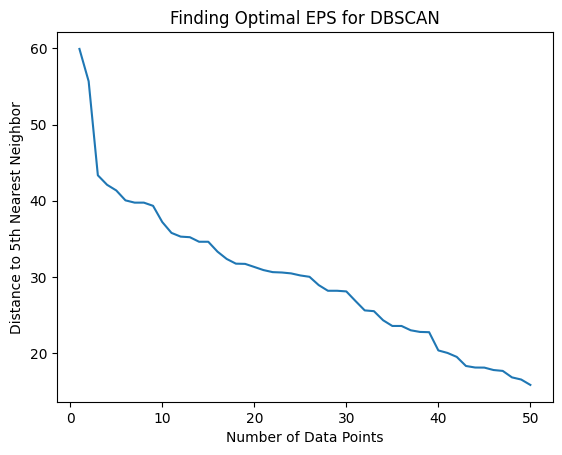

In [189]:
from sklearn.neighbors import NearestNeighbors

def find_optimal_eps_dbscan(data, min_samples=5):
    nn = NearestNeighbors(n_neighbors=min_samples)
    nbrs = nn.fit(data)
    distances, indices = nbrs.kneighbors(data)

    # Ordena las distancias y plotea
    distanceDec = sorted(distances[:, min_samples-1], reverse=True)
    plt.plot(list(range(1, len(distanceDec) + 1)), distanceDec)
    plt.xlabel("Number of Data Points")
    plt.ylabel("Distance to " + str(min_samples) + "th Nearest Neighbor")
    plt.title("Finding Optimal EPS for DBSCAN")
    plt.show()

# Ejemplo:
find_optimal_eps_dbscan(df_crimenes_db)

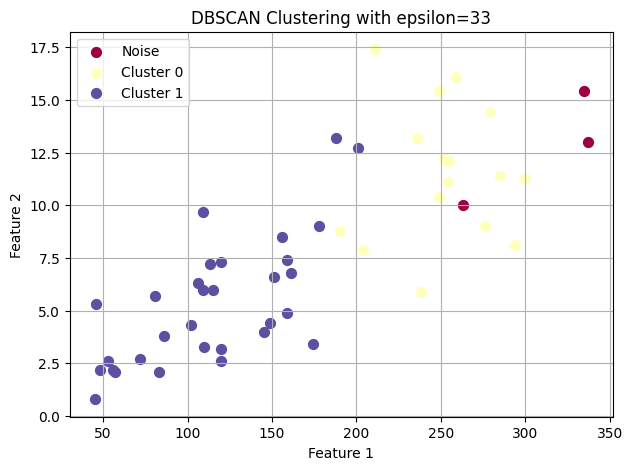

In [190]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Ajusta DBSCAN
db = DBSCAN(eps=35, min_samples=5).fit(df_crimenes_db)

# Etiquetas de cluster
labels = db.labels_

# Grafica los resultados
plt.figure(figsize=(7, 5))
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = df_crimenes_db[class_member_mask]
    plt.scatter(xy['Asaltos'], xy['Asesinatos'], s=50, color=color, label='Cluster {}'.format(label) if label != -1 else 'Noise')

plt.title('DBSCAN Clustering with epsilon=33')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.legend()
plt.show()

In [191]:
df_crimenes_db['clusters'] = labels

In [192]:
df_crimenes_db.head(20)

Estado  Asesinatos  Asaltos  Poblacion Urbana  Violaciones  clusters
0        0        13.2      236                58         21.2         0
1        1        10.0      263                48         44.5        -1
2        2         8.1      294                80         31.0         0
3        3         8.8      190                50         19.5         0
4        4         9.0      276                91         40.6         0
5        5         7.9      204                78         38.7         0
6        6         3.3      110                77         11.1         1
7        7         5.9      238                72         15.8         0
8        8        15.4      335                80         31.9        -1
9        9        17.4      211                60         25.8         0
10      10         5.3       46                83         20.2         1
11      11         2.6      120                54         14.2         1
12      12        10.4      249                83         24.0         0
13      13         7.2      113                65         21.0         1
14      14         2.2       56                57         11.3         1
15      15         6.0      115                66         18.0         1
16      16         9.7      109                52         16.3         1
17      17        15.4      249                66         22.2         0
18      18         2.1       83                51          7.8         1
19      19        11.3      300                67         27.8         0

In [193]:
etiquetas = {0: 'Peligro', 1: 'Seguro', -1: 'Indefinido'}
df_crimenes_db['Nivel_Seguridad'] = df_crimenes_db['clusters'].map(etiquetas)
df_crimenes_db = df_crimenes_db.drop('clusters', axis=1)
df_crimenes_db = df_crimenes_db.drop('Poblacion Urbana', axis=1)
df_crimenes_db.head()

Estado  Asesinatos  Asaltos  Violaciones Nivel_Seguridad
0       0        13.2      236         21.2         Peligro
1       1        10.0      263         44.5      Indefinido
2       2         8.1      294         31.0         Peligro
3       3         8.8      190         19.5         Peligro
4       4         9.0      276         40.6         Peligro

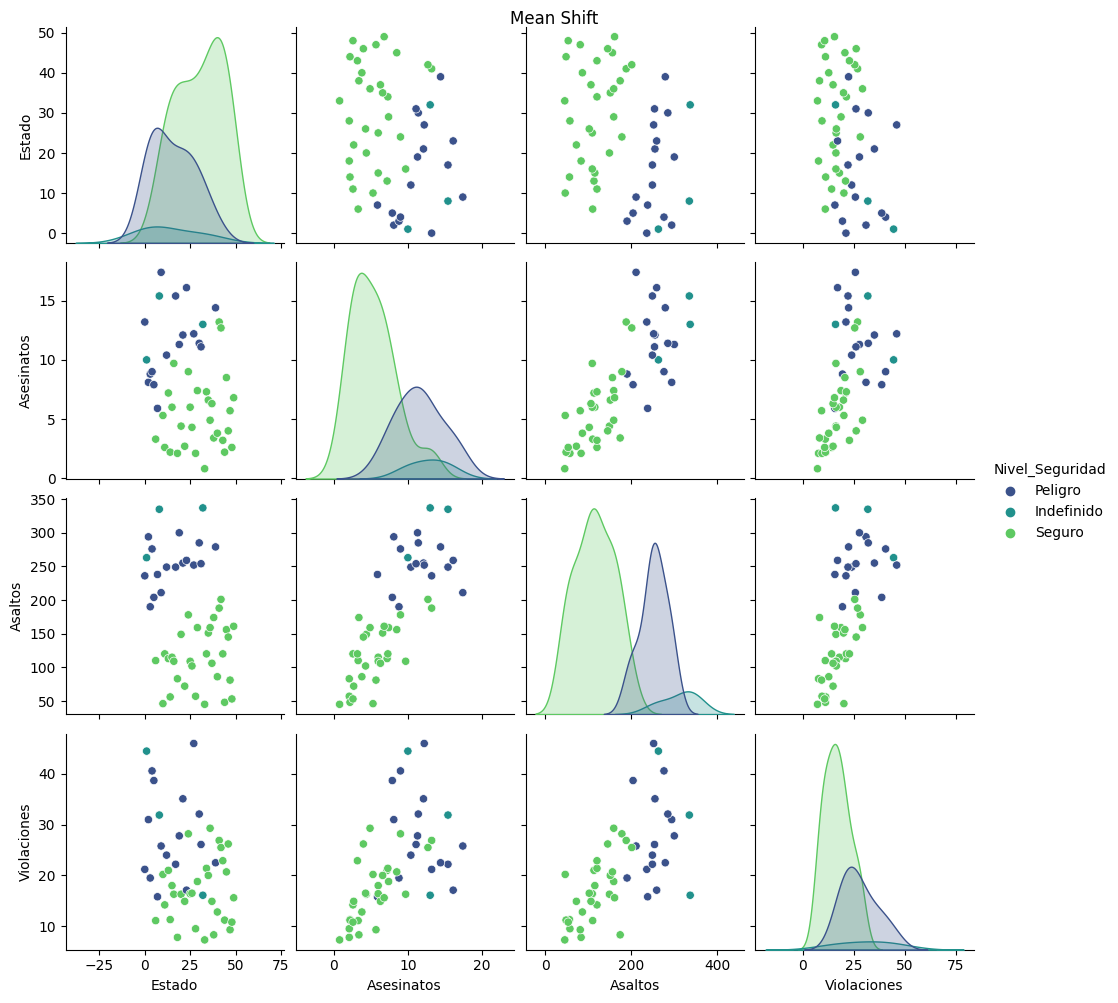

In [195]:
sns.pairplot(df_crimenes_db, hue='Nivel_Seguridad', palette='viridis')
plt.suptitle('Mean Shift', y=1)
plt.show()

# Clustering

## Crimenes


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MeanShift, DBSCAN

In [ ]:
path = '/content/drive/MyDrive/UPSO ML & BD/DatasetClustering/Crimenes.csv'

In [ ]:
df = pd.read_csv(path)   #cargar el archivo csv en un df
df_crimenes = df.copy()  #copia del df original
df_crimenes.head()

Estado  Asesinatos  Asaltos  Poblacion Urbana  Violaciones
0     Alabama        13.2      236                58         21.2
1      Alaska        10.0      263                48         44.5
2     Arizona         8.1      294                80         31.0
3    Arkansas         8.8      190                50         19.5
4  California         9.0      276                91         40.6

In [ ]:
df_crimenes.tail()

Estado  Asesinatos  Asaltos  Poblacion Urbana  Violaciones
45       Virginia         8.5      156                63         20.7
46     Washington         4.0      145                73         26.2
47  West Virginia         5.7       81                39          9.3
48      Wisconsin         2.6       53                66         10.8
49        Wyoming         6.8      161                60         15.6

In [ ]:
df_crimenes.describe()

Asesinatos     Asaltos  Poblacion Urbana  Violaciones
count    50.00000   50.000000         50.000000    50.000000
mean      7.78800  170.760000         65.540000    21.232000
std       4.35551   83.337661         14.474763     9.366385
min       0.80000   45.000000         32.000000     7.300000
25%       4.07500  109.000000         54.500000    15.075000
50%       7.25000  159.000000         66.000000    20.100000
75%      11.25000  249.000000         77.750000    26.175000
max      17.40000  337.000000         91.000000    46.000000

In [ ]:
df_crimenes.shape

(50, 5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


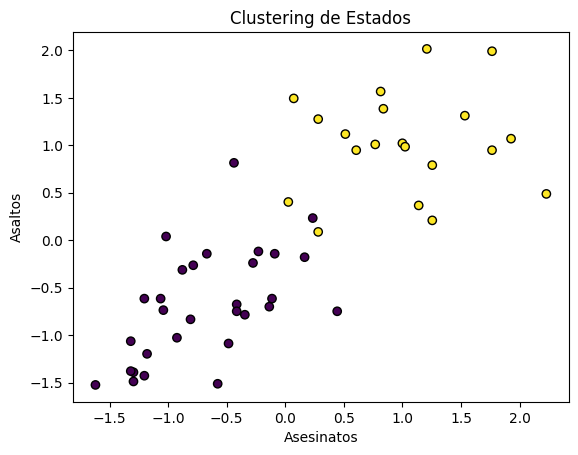

In [ ]:
from sklearn.preprocessing import StandardScaler
X = df_crimenes[['Asesinatos', 'Asaltos', 'Poblacion Urbana', 'Violaciones']]

# Escalando los datos para que todas las características tengan la misma escala
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elegir el número de clusters (puedes ajustar este valor)
num_clusters = 2

# Aplicar el algoritmo de k-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_crimenes['cluster'] = kmeans.fit_predict(X_scaled)

# Visualizar los resultados (esto dependerá del número de dimensiones de tus datos)
# Puedes ajustar esto dependiendo de tus columnas
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df_crimenes['cluster'], cmap='viridis', edgecolor='k')
plt.title('Clustering de Estados')
plt.xlabel('Asesinatos')
plt.ylabel('Asaltos')
plt.show()

<ipython-input-20-9b8d32cade2d>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_crimenes['Asesinatos'], df_crimenes['Violaciones'], s=50, cmap='viridis')


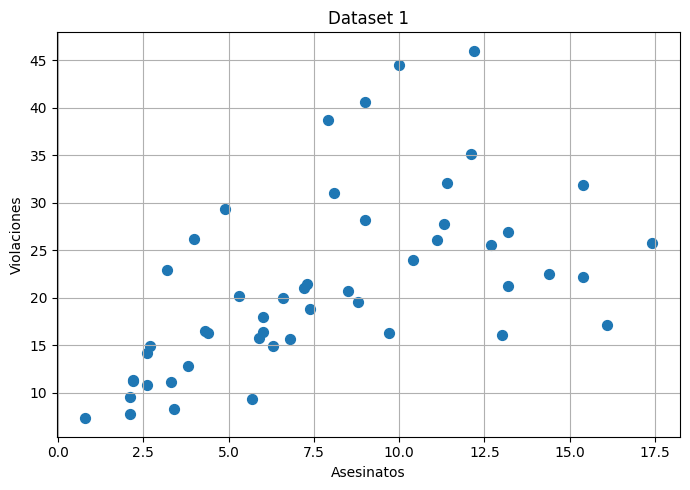

In [ ]:
# Datos a visualizar

plt.figure(figsize=(7, 5))  # Cambiamos el tamaño de la figura

# Dibujar el scatter plot para data1
plt.scatter(df_crimenes['Asesinatos'], df_crimenes['Violaciones'], s=50, cmap='viridis')
plt.title('Dataset 1')
plt.xlabel("Asesinatos")
plt.ylabel("Violaciones")
plt.grid(True)

plt.tight_layout()
plt.show()

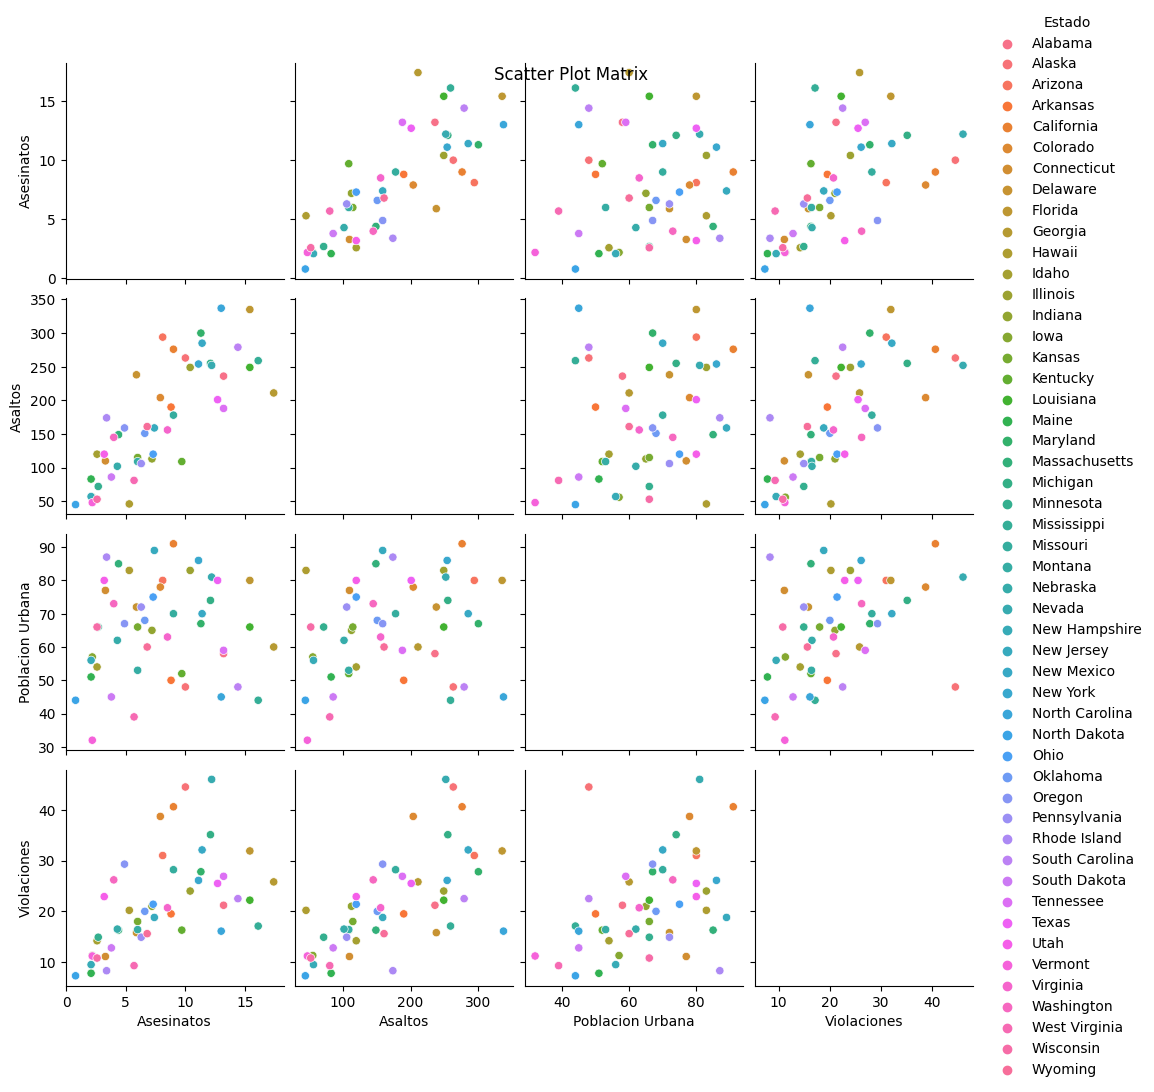

In [ ]:
import seaborn as sns

custom_palette = sns.color_palette("husl", n_colors=len(df_crimenes['Estado'].unique()))
# Creo un pairplot con todas las columnas numéricas delDataFrame
sns.set_palette(custom_palette)
sns.pairplot(df_crimenes, diag_kind='kde', markers='o', hue='Estado')
plt.suptitle('Scatter Plot Matrix')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Crea una instancia del LabelEncoder
label_encoder = LabelEncoder()

# Aplica la codificación a la columna 'Estado'
df_crimenes['Estado'] = label_encoder.fit_transform(df_crimenes['Estado'])
df_crimenes.head()

Estado  Asesinatos  Asaltos  Poblacion Urbana  Violaciones
0       0        13.2      236                58         21.2
1       1        10.0      263                48         44.5
2       2         8.1      294                80         31.0
3       3         8.8      190                50         19.5
4       4         9.0      276                91         40.6

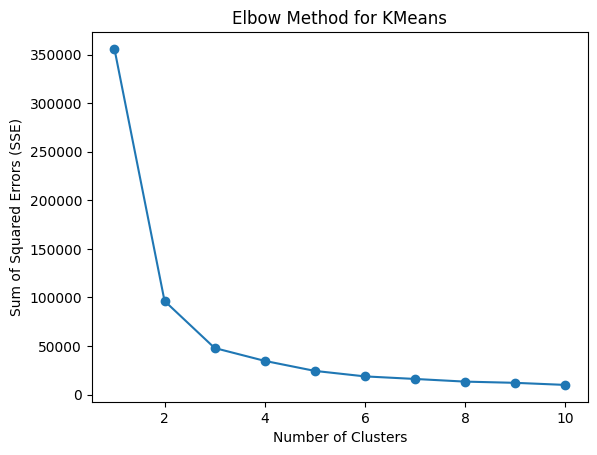

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_optimal_clusters_kmeans(data, max_k):
    sse = [] # Sum of squared errors
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, n_init=max_k).fit(data)
        sse.append(kmeans.inertia_)

    plt.plot(range(1, max_k+1), sse, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.title("Elbow Method for KMeans")
    plt.show()

# Ejemplo:
find_optimal_clusters_kmeans(X, 10)

In [ ]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


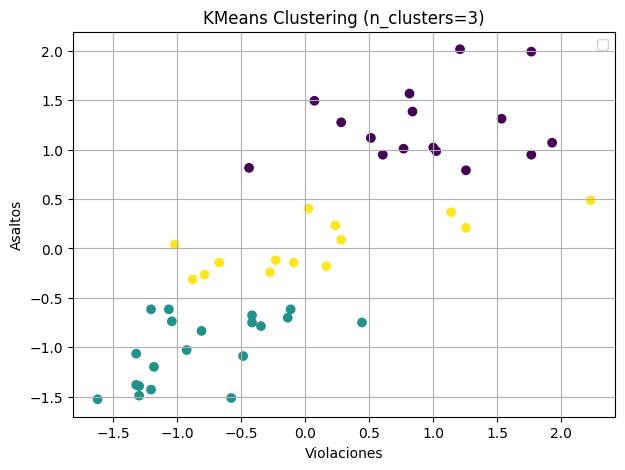

In [ ]:
#X_scaled con StandardScaler de  SKlearn

df_crimenes['cluster'] = kmeans.fit_predict(X)
plt.figure(figsize=(7, 5))

X_scaled = scaler.fit_transform(X)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df_crimenes['cluster'], cmap='viridis')
plt.title('KMeans Clustering (n_clusters=3)')
plt.xlabel("Violaciones")
plt.ylabel("Asaltos")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Aca estan los resultados del modelo
df_resultados = df_crimenes[['Estado','cluster']]
df_resultados

Estado  cluster
0          Alabama        0
1           Alaska        0
2          Arizona        0
3         Arkansas        2
4       California        0
5         Colorado        2
6      Connecticut        1
7         Delaware        0
8          Florida        0
9          Georgia        2
10          Hawaii        1
11           Idaho        1
12        Illinois        0
13         Indiana        1
14            Iowa        1
15          Kansas        1
16        Kentucky        1
17       Louisiana        0
18           Maine        1
19        Maryland        0
20   Massachusetts        2
21        Michigan        0
22       Minnesota        1
23     Mississippi        0
24        Missouri        2
25         Montana        1
26        Nebraska        1
27          Nevada        0
28   New Hampshire        1
29      New Jersey        2
30      New Mexico        0
31        New York        0
32  North Carolina        0
33    North Dakota        1
34            Ohio        1
35        Oklahoma        2
36          Oregon        2
37    Pennsylvania        1
38    Rhode Island        2
39  South Carolina        0
40    South Dakota        1
41       Tennessee        2
42           Texas        2
43            Utah        1
44         Vermont        1
45        Virginia        2
46      Washington        2
47   West Virginia        1
48       Wisconsin        1
49         Wyoming        2

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler


# Coordenadas predefinidas para las ciudades en tu DataFrame
coordenadas = {
    "Boston": (42.3601, -71.0589),
    "Los Angeles": (34.0522, -118.2437),
    "San Francisco": (37.7749, -122.4194),
    "Dallas": (32.7767, -96.7970),
    "Seattle": (47.6062, -122.3321),
    "Atlanta": (33.7490, -84.3880),
    "New York City": (40.7128, -74.0060),
    "Portland": (45.5122, -122.6587),
    "Austin": (30.2672, -97.7431),
}

# Agrupar por ciudad y sumar las ventas
ventas_por_ciudad = df_total.groupby('Ciudad')['Ventas'].sum().reset_index()

# Añadir las coordenadas de latitud y longitud al DataFrame
ventas_por_ciudad['Latitud'] = ventas_por_ciudad['Ciudad'].map(lambda x: coordenadas.get(x, (None, None))[0])
ventas_por_ciudad['Longitud'] = ventas_por_ciudad['Ciudad'].map(lambda x: coordenadas.get(x, (None, None))[1])

# Escalar las ventas a un rango de tamaños de burbuja
scaler = MinMaxScaler(feature_range=(10, 50))  # El rango (10, 50) es solo un ejemplo, puedes ajustarlo según tus necesidades
ventas_por_ciudad['Ventas_escaladas'] = scaler.fit_transform(ventas_por_ciudad[['Ventas']])

# Crear subplots: 1 fila, 2 columnas
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.3, 0.9],
    subplot_titles=('Ventas por Ciudad', 'Mapa de Ventas'),
    specs=[[{"type": "xy"}, {"type": "geo"}]]  # Especificar el tipo de subplot
)

# Añadir gráfico de barras a la primera columna
fig.add_trace(
    go.Bar(
        y=ventas_por_ciudad['Ciudad'],
        x=ventas_por_ciudad['Ventas'],
        orientation='h',
        marker=dict(color=ventas_por_ciudad['Ventas'], colorscale='Cividis')
    ),
    row=1, col=1
)

# Añadir mapa a la segunda columna
fig.add_trace(
    go.Scattergeo(
        lon=ventas_por_ciudad['Longitud'],
        lat=ventas_por_ciudad['Latitud'],
        text=ventas_por_ciudad['Ciudad'] + ": " + ventas_por_ciudad['Ventas'].astype(str),
        marker=dict(
            color=ventas_por_ciudad['Ventas'],
            colorscale='Cividis',
            size=ventas_por_ciudad['Ventas_escaladas'],
            sizemode='diameter',
            showscale=True,
            colorbar=dict(y=0.4)
        ),
    ),
    row=1, col=2
)

# Configurar el layout del gráfico
fig.update_layout(
    title_text='Ventas por Ciudad en Estados Unidos',
    title_x=0.5,  # Centrar el título
    geo=dict(scope='usa', domain=dict(x=[0.3, 1], y=[0, 1])),  # Ajustar el dominio del subplot geo
    width=1200,
    height=600
)

fig.show()


In [ ]:
df_resultados.sort_values(by='cluster' , ascending=False)

Estado  cluster
49         Wyoming        2
9          Georgia        2
29      New Jersey        2
20   Massachusetts        2
35        Oklahoma        2
36          Oregon        2
38    Rhode Island        2
24        Missouri        2
42           Texas        2
41       Tennessee        2
45        Virginia        2
46      Washington        2
5         Colorado        2
3         Arkansas        2
43            Utah        1
44         Vermont        1
40    South Dakota        1
37    Pennsylvania        1
47   West Virginia        1
34            Ohio        1
33    North Dakota        1
48       Wisconsin        1
28   New Hampshire        1
26        Nebraska        1
25         Montana        1
15          Kansas        1
13         Indiana        1
22       Minnesota        1
6      Connecticut        1
10          Hawaii        1
18           Maine        1
11           Idaho        1
16        Kentucky        1
14            Iowa        1
2          Arizona        0
4       California        0
7         Delaware        0
8          Florida        0
12        Illinois        0
1           Alaska        0
39  South Carolina        0
23     Mississippi        0
17       Louisiana        0
19        Maryland        0
32  North Carolina        0
31        New York        0
30      New Mexico        0
21        Michigan        0
27          Nevada        0
0          Alabama        0

In [ ]:
df_crimenes.columns

Index(['Estado', 'Asesinatos', 'Asaltos', 'Poblacion Urbana', 'Violaciones'], dtype='object')

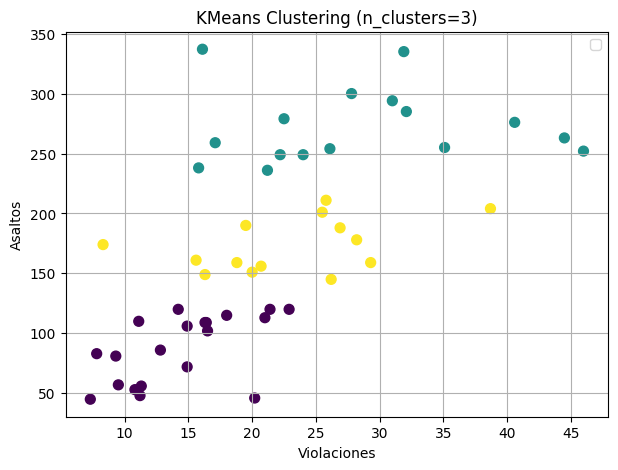

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(df_crimenes['Violaciones'], df_crimenes['Asaltos'], c=clusters, s=50, cmap='viridis')
plt.title('KMeans Clustering (n_clusters=3)')
plt.xlabel("Violaciones")
plt.ylabel("Asaltos")
plt.legend()
plt.grid(True)
plt.show()

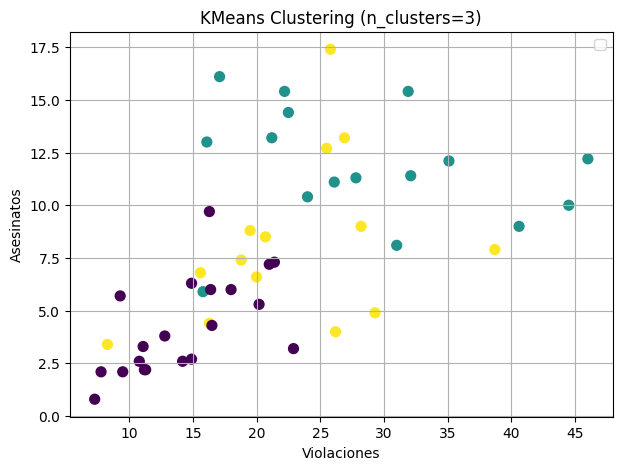

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(df_crimenes['Violaciones'], df_crimenes['Asesinatos'], c=clusters, s=50, cmap='viridis')
plt.title('KMeans Clustering (n_clusters=3)')
plt.xlabel("Violaciones")
plt.ylabel("Asesinatos")
plt.legend()
plt.grid(True)
plt.show()

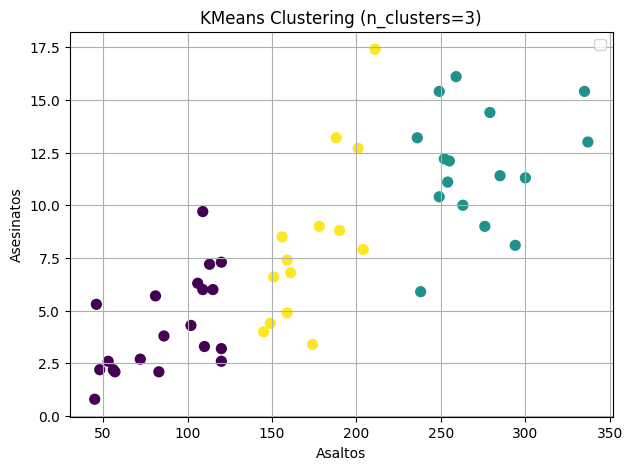

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(df_crimenes['Asaltos'], df_crimenes['Asesinatos'], c=clusters, s=50, cmap='viridis')
plt.title('KMeans Clustering (n_clusters=3)')
plt.xlabel("Asaltos")
plt.ylabel("Asesinatos")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


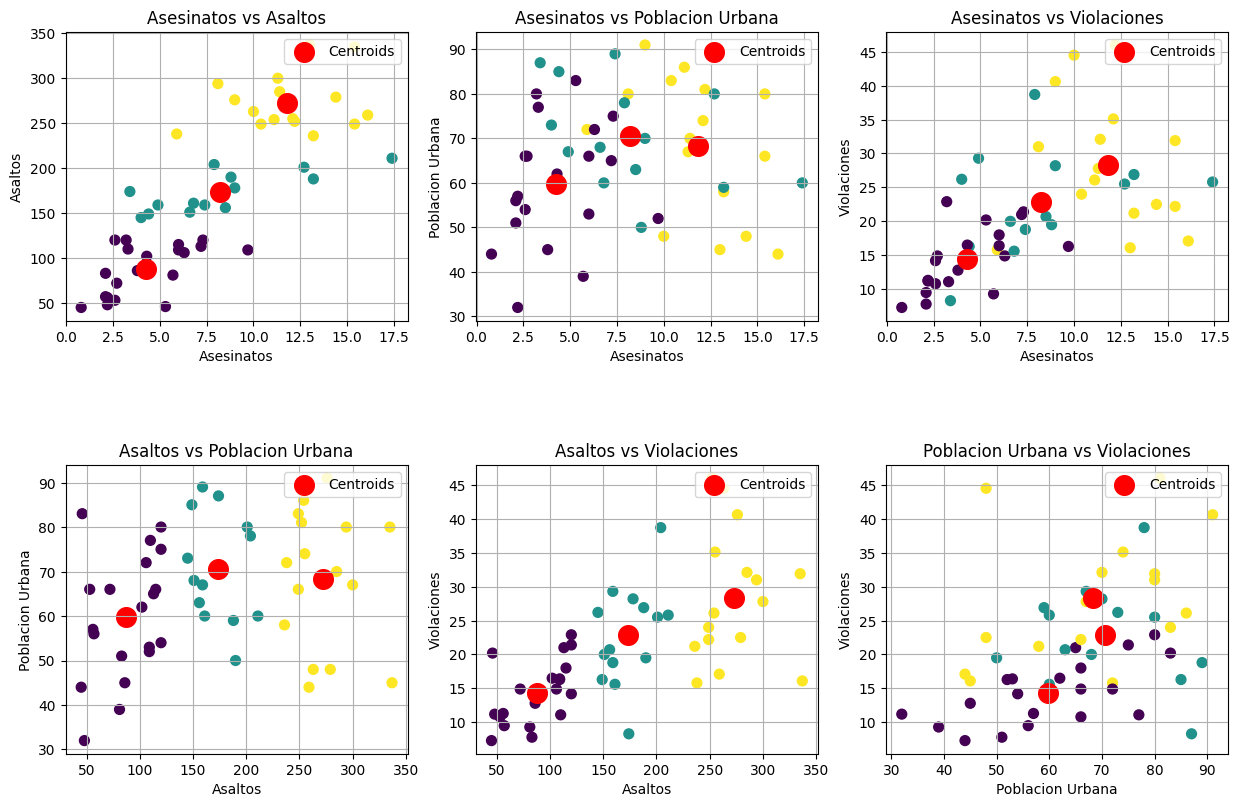

In [ ]:
import itertools

feature_combinations = list(itertools.combinations(df_crimenes.columns[1:], 2))  # Excluye la columna 'Estado'

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_crimenes.iloc[:, 1:])

fig, axes = plt.subplots(nrows=len(feature_combinations) // 3 + 1, ncols=3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)

for i, feature_combination in enumerate(feature_combinations):
    row, col = i // 3, i % 3
    feature1, feature2 = feature_combination
    ax = axes[row, col]

    ax.scatter(df_crimenes[feature1], df_crimenes[feature2], c=kmeans.labels_, cmap='viridis', s=50)
    ax.scatter(kmeans.cluster_centers_[:, df_crimenes.columns.get_loc(feature1) - 1],
               kmeans.cluster_centers_[:, df_crimenes.columns.get_loc(feature2) - 1],
               s=200, c='red', marker='o', label="Centroids")

    ax.set_title(f'{feature1} vs {feature2}')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.legend(loc='upper right')
    ax.grid(True)

for i in range(len(feature_combinations), len(axes.flat)):
    fig.delaxes(axes.flat[i])

plt.show()


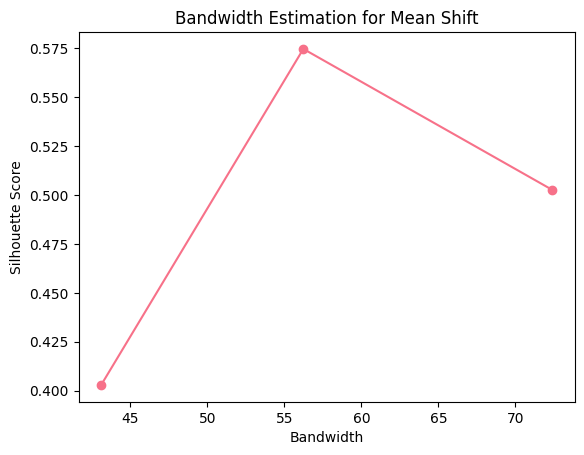

In [ ]:
from sklearn.cluster import estimate_bandwidth

def estimate_bandwidth_meanshift(data, quantile_range=(0.2, 0.5), step=0.1):
    bandwidths = []
    silhouettes = []

    quantiles = np.arange(quantile_range[0], quantile_range[1], step)

    for quantile in quantiles:
        bandwidth = estimate_bandwidth(data, quantile=quantile)
        bandwidths.append(bandwidth)

        ms = MeanShift(bandwidth=bandwidth).fit(data)
        if len(np.unique(ms.labels_)) > 1:
            sil_score = silhouette_score(data, ms.labels_)
            silhouettes.append(sil_score)
        else:
            silhouettes.append(-1)

    plt.plot(bandwidths, silhouettes, 'o-')
    plt.xlabel("Bandwidth")
    plt.ylabel("Silhouette Score")
    plt.title("Bandwidth Estimation for Mean Shift")
    plt.show()

estimate_bandwidth_meanshift(df_crimenes)

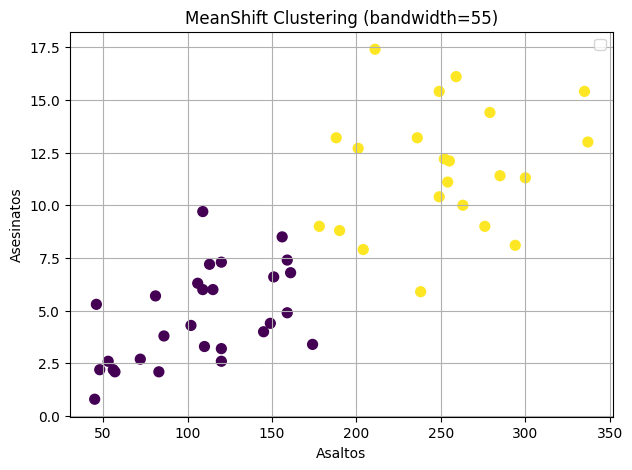

In [ ]:
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

# Aplicar MeanShift con bandwidth=1.6
bandwidth =55
ms = MeanShift(bandwidth=bandwidth).fit(df_crimenes)
labels = ms.labels_

# Graficar los resultados
plt.figure(figsize=(7, 5))
plt.scatter(df_crimenes['Asaltos'], df_crimenes['Asesinatos'], c=labels, s=50, cmap='viridis')
# plt.scatter(ms.cluster_centers_[:, 0], ms.cluster_centers_[:, 1], s=200, c='red', marker='X', label="Centroids")
plt.title(f'MeanShift Clustering (bandwidth={bandwidth})')
plt.xlabel("Asaltos")
plt.ylabel("Asesinatos")
plt.legend()
plt.grid(True)
plt.show()

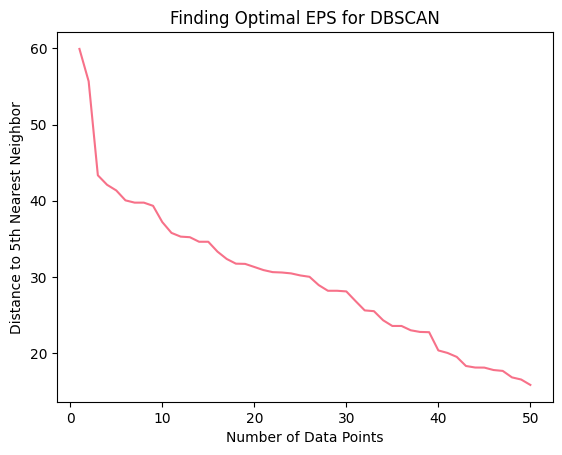

In [ ]:

from sklearn.neighbors import NearestNeighbors

def find_optimal_eps_dbscan(data, min_samples=5):
    nn = NearestNeighbors(n_neighbors=min_samples)
    nbrs = nn.fit(data)
    distances, indices = nbrs.kneighbors(data)

    # Ordena las distancias y plotea
    distanceDec = sorted(distances[:, min_samples-1], reverse=True)
    plt.plot(list(range(1, len(distanceDec) + 1)), distanceDec)
    plt.xlabel("Number of Data Points")
    plt.ylabel("Distance to " + str(min_samples) + "th Nearest Neighbor")
    plt.title("Finding Optimal EPS for DBSCAN")
    plt.show()

# Ejemplo:
find_optimal_eps_dbscan(df_crimenes)

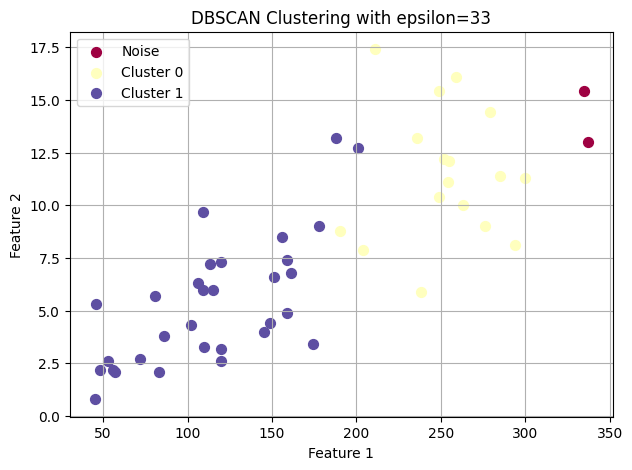

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Ajusta DBSCAN
db = DBSCAN(eps=36, min_samples=5).fit(df_crimenes)

# Etiquetas de cluster
labels = db.labels_

# Grafica los resultados
plt.figure(figsize=(7, 5))
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = df_crimenes[class_member_mask]
    plt.scatter(xy['Asaltos'], xy['Asesinatos'], s=50, color=color, label='Cluster {}'.format(label) if label != -1 else 'Noise')

plt.title('DBSCAN Clustering with epsilon=33')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.legend()
plt.show()

## Salarios

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MeanShift, DBSCAN

In [ ]:
path_s = '/content/drive/MyDrive/UPSO ML & BD/DatasetClustering/Salarios.csv'

In [ ]:
df = pd.read_csv(path_s)   #cargar el archivo csv en un df
df_salarios = df.copy()  #copia del df original
df_salarios.head()

league  player_id  salary   season  season_end  season_start  \
0    NBA  abdelal01  395000  1990-91        1991          1990   
1    NBA  abdelal01  494000  1991-92        1992          1991   
2    NBA  abdelal01  500000  1992-93        1993          1992   
3    NBA  abdelal01  805000  1993-94        1994          1993   
4    NBA  abdelal01  650000  1994-95        1995          1994   

                     team  
0  Portland Trail Blazers  
1  Portland Trail Blazers  
2          Boston Celtics  
3          Boston Celtics  
4        Sacramento Kings

In [ ]:
df_salarios.tail()

league  player_id   salary   season  season_end  season_start  \
14158    NBA  zipsepa01   750000  2016-17        2017          2016   
14159    NBA  zipsepa01  1312611  2017-18        2018          2017   
14160    NBA  zizican01  1645200  2017-18        2018          2017   
14161    NBA  zubaciv01  1034956  2016-17        2017          2016   
14162    NBA  zubaciv01  1312611  2017-18        2018          2017   

                      team  
14158        Chicago Bulls  
14159        Chicago Bulls  
14160  Cleveland Cavaliers  
14161   Los Angeles Lakers  
14162   Los Angeles Lakers

In [ ]:
df_salarios.shape

(14163, 7)

In [ ]:
X = df_salarios[['salary']]

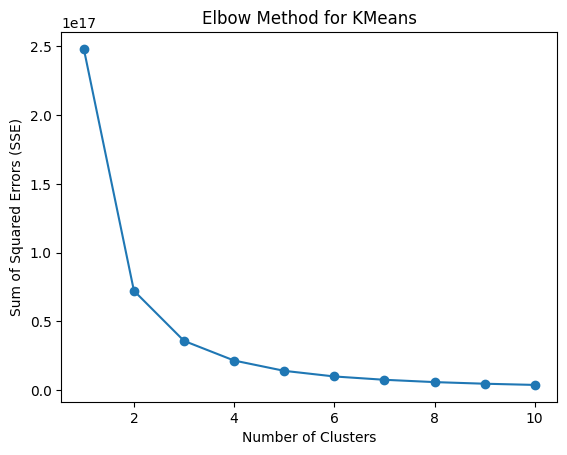

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_optimal_clusters_kmeans(data, max_k):
    sse = [] # Sum of squared errors
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, n_init=max_k).fit(data)
        sse.append(kmeans.inertia_)

    plt.plot(range(1, max_k+1), sse, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.title("Elbow Method for KMeans")
    plt.show()

# Ejemplo:
find_optimal_clusters_kmeans(X, 10)

In [ ]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df_salarios['cluster'] = clusters


In [ ]:
df_salarios.head()

league  player_id  salary   season  season_end  season_start  \
0    NBA  abdelal01  395000  1990-91        1991          1990   
1    NBA  abdelal01  494000  1991-92        1992          1991   
2    NBA  abdelal01  500000  1992-93        1993          1992   
3    NBA  abdelal01  805000  1993-94        1994          1993   
4    NBA  abdelal01  650000  1994-95        1995          1994   

                     team  cluster  
0  Portland Trail Blazers        1  
1  Portland Trail Blazers        1  
2          Boston Celtics        1  
3          Boston Celtics        1  
4        Sacramento Kings        1

<Axes: xlabel='cluster', ylabel='salary'>

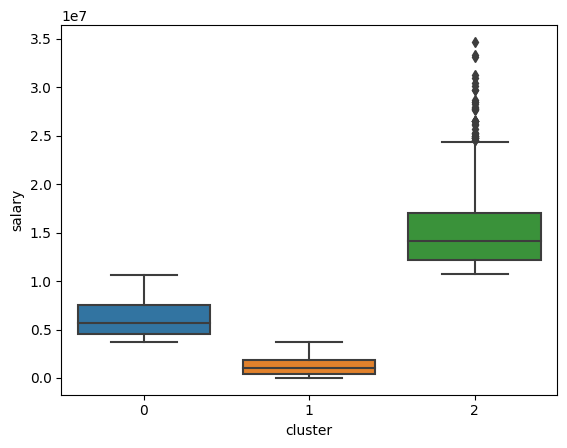

In [ ]:
import seaborn as sns
sns.boxplot(x='cluster', y='salary', data=df_salarios)


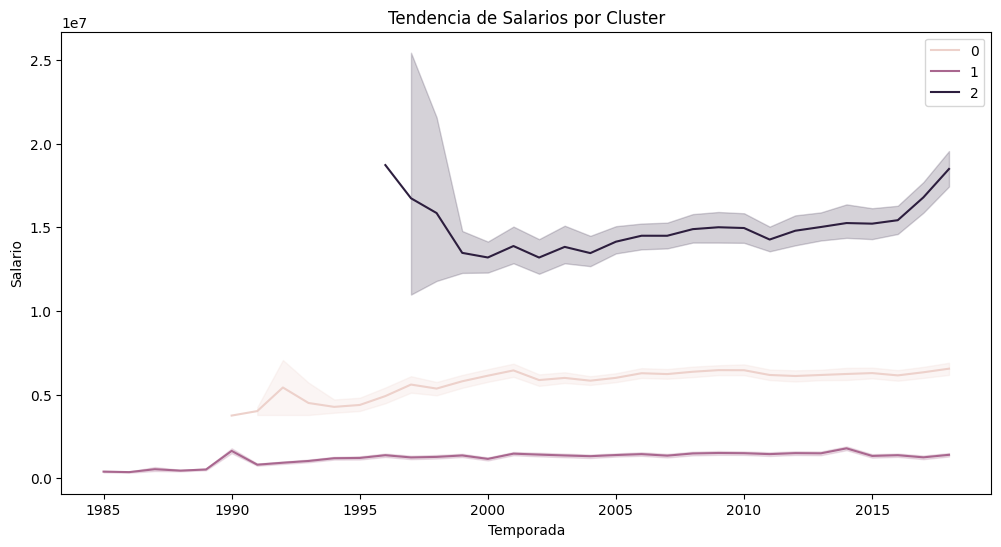

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.lineplot(x='season_end', y='salary', hue=clusters, data=df)
plt.title('Tendencia de Salarios por Cluster')
plt.xlabel('Temporada')
plt.ylabel('Salario')
plt.show()


In [ ]:
cluster_stats = df.groupby('cluster')['salary'].describe()
print(cluster_stats)


KeyError: ignored

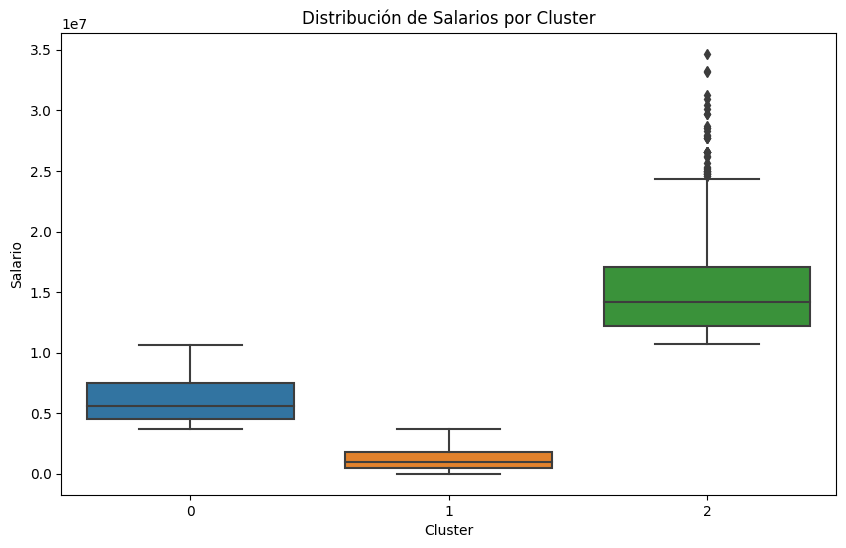

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=clusters, y='salary', data=df)
plt.title('Distribución de Salarios por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Salario')
plt.show()


In [ ]:
df_salarios.columns


Index(['league', 'player_id', 'salary', 'season', 'season_end', 'season_start',
       'team', 'cluster'],
      dtype='object')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que 'season_end' es de tipo datetime
df['season_end'] = pd.to_datetime(df['season_end'])

# Tendencia de salarios por cluster a lo largo del tiempo
plt.figure(figsize=(12, 6))
sns.lineplot(x='season_end', y='salary', hue=clusters, data=df)
plt.title('Tendencia de Salarios por Cluster a lo Largo del Tiempo')
plt.xlabel('Temporada')
plt.ylabel('Salario')
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
df_salarios.columns

Index(['league', 'player_id', 'salary', 'season', 'season_end', 'season_start',
       'team', 'cluster'],
      dtype='object')

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_salarios[['salary']])


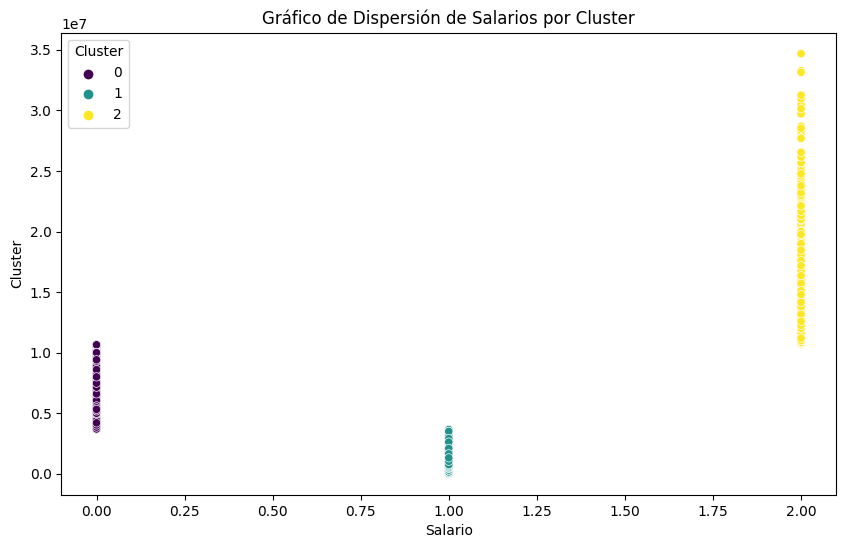

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grafico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cluster', y='salary', data=df_salarios, hue='cluster', palette='viridis')
plt.title('Gráfico de Dispersión de Salarios por Cluster')
plt.xlabel('Salario')
plt.ylabel('Cluster')
plt.legend(title='Cluster')
plt.show()


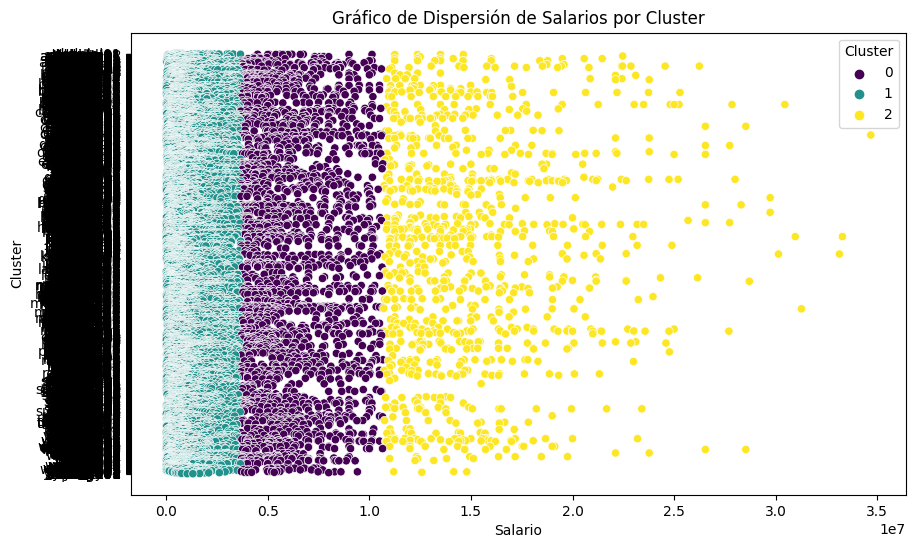

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grafico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='salary', y='player_id', data=df_salarios, hue='cluster', palette='viridis')
plt.title('Gráfico de Dispersión de Salarios por Cluster')
plt.xlabel('Salario')
plt.ylabel('Cluster')
plt.legend(title='Cluster')
plt.show()


<ipython-input-61-f944e7204c20>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='salary', y='cluster', data=df_salarios, palette='viridis')


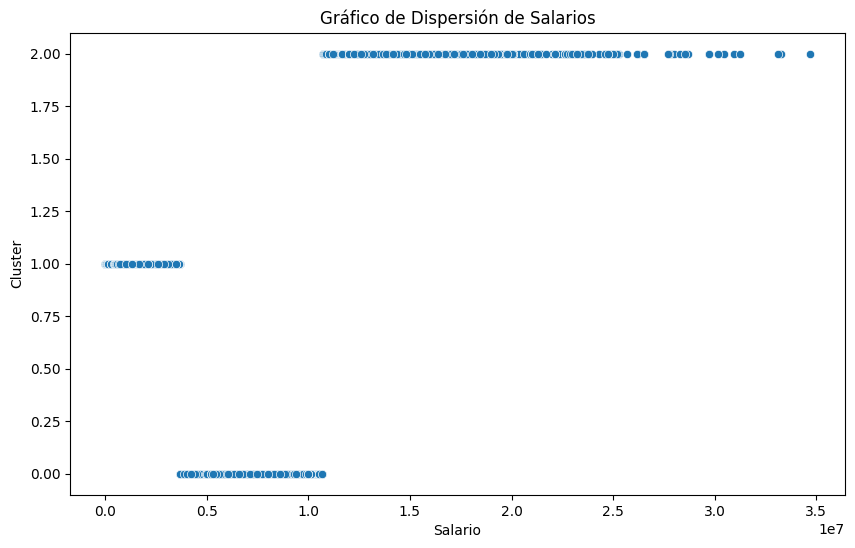

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='salary', y='cluster', data=df_salarios, palette='viridis')
plt.title('Gráfico de Dispersión de Salarios')
plt.xlabel('Salario')
plt.ylabel('Cluster')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

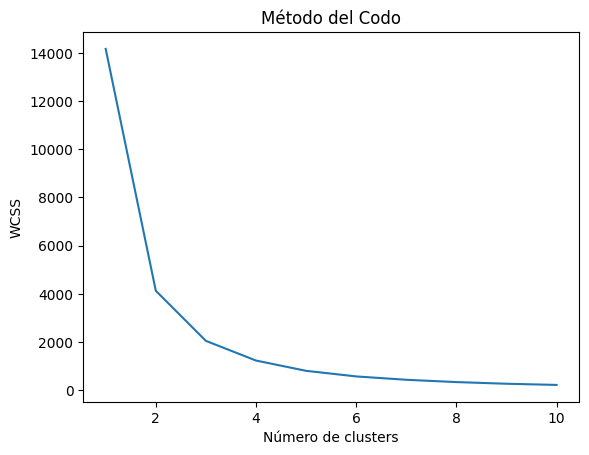

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Graficar el método del codo
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')  # within-cluster sum of squares
plt.show()


In [ ]:
k = 3  # ajusta este valor según el resultado del método del codo
kmeans_model = KMeans(n_clusters=k, init='k-means++', random_state=42)
df_salarios['cluster'] = kmeans_model.fit_predict(df_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


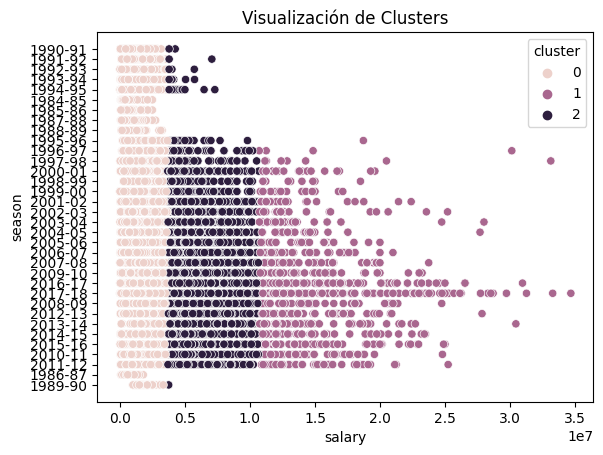

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualización bidimensional (por ejemplo, salary vs. otra característica)
sns.scatterplot(x='salary', y='season', hue='cluster', data=df_salarios)
plt.title('Visualización de Clusters')
plt.show()


In [ ]:
cluster_stats = df_salarios.groupby('cluster')['salary'].describe()
print(cluster_stats)


           count          mean           std         min          25%  \
cluster                                                                 
0        10462.0  1.224679e+06  9.501307e+05      2706.0    450000.00   
1         1018.0  1.526667e+07  4.070192e+06  10714000.0  12205555.25   
2         2683.0  6.138651e+06  1.887123e+06   3678319.0   4529650.00   

                50%          75%         max  
cluster                                       
0         1000000.0   1823280.00   3676000.0  
1        14142480.0  17054795.25  34682550.0  
2         5632200.0   7500000.00  10670000.0  


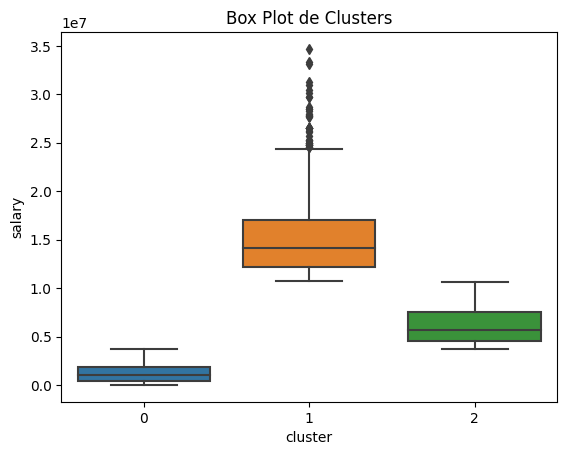

In [ ]:
sns.boxplot(x='cluster', y='salary', data=df_salarios)
plt.title('Box Plot de Clusters')
plt.show()


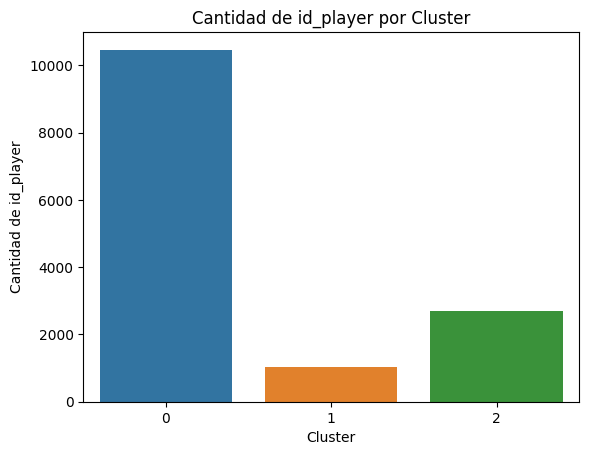

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por cluster y contar la cantidad de id_player en cada cluster
cluster_counts = df_salarios['cluster'].value_counts()

# Graficar el gráfico de barras
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Cantidad de id_player por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de id_player')
plt.show()


In [ ]:
from sklearn.cluster import estimate_bandwidth

def estimate_bandwidth_meanshift(data, quantile_range=(0.2, 0.5), step=0.1):
    bandwidths = []
    silhouettes = []

    quantiles = np.arange(quantile_range[0], quantile_range[1], step)

    for quantile in quantiles:
        bandwidth = estimate_bandwidth(data, quantile=quantile)
        bandwidths.append(bandwidth)

        ms = MeanShift(bandwidth=bandwidth).fit(data)
        if len(np.unique(ms.labels_)) > 1:
            sil_score = silhouette_score(data, ms.labels_)
            silhouettes.append(sil_score)
        else:
            silhouettes.append(-1)

    plt.plot(bandwidths, silhouettes, 'o-')
    plt.xlabel("Bandwidth")
    plt.ylabel("Silhouette Score")
    plt.title("Bandwidth Estimation for Mean Shift")
    plt.show()

estimate_bandwidth_meanshift(df_salarios[['salary', 'cluster']])

KeyboardInterrupt: ignored

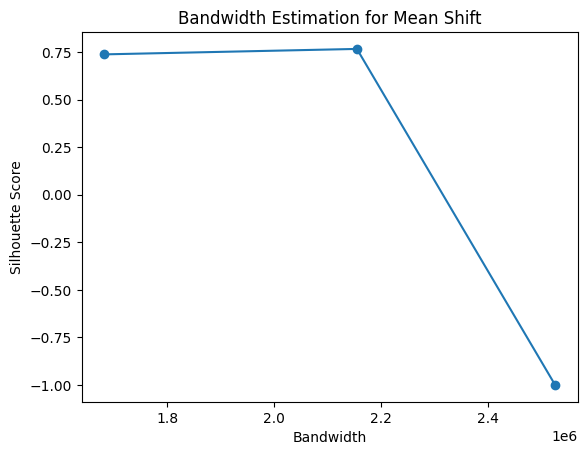

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import estimate_bandwidth, MeanShift
from sklearn.metrics import silhouette_score

def estimate_bandwidth_meanshift(data, quantile_range=(0.2, 0.5), step=0.1):
    bandwidths = []
    silhouettes = []

    quantiles = np.arange(quantile_range[0], quantile_range[1], step)

    for quantile in quantiles:
        bandwidth = estimate_bandwidth(data, quantile=quantile)
        bandwidths.append(bandwidth)

        ms = MeanShift(bandwidth=bandwidth).fit(data)
        if len(np.unique(ms.labels_)) > 1:
            sil_score = silhouette_score(data, ms.labels_)
            silhouettes.append(sil_score)
        else:
            silhouettes.append(-1)

    plt.plot(bandwidths, silhouettes, 'o-')
    plt.xlabel("Bandwidth")
    plt.ylabel("Silhouette Score")
    plt.title("Bandwidth Estimation for Mean Shift")
    plt.show()

# Utiliza solo la columna 'salary' para la estimación del ancho de banda
data_for_bandwidth = df_salarios[['salary']]
estimate_bandwidth_meanshift(data_for_bandwidth)


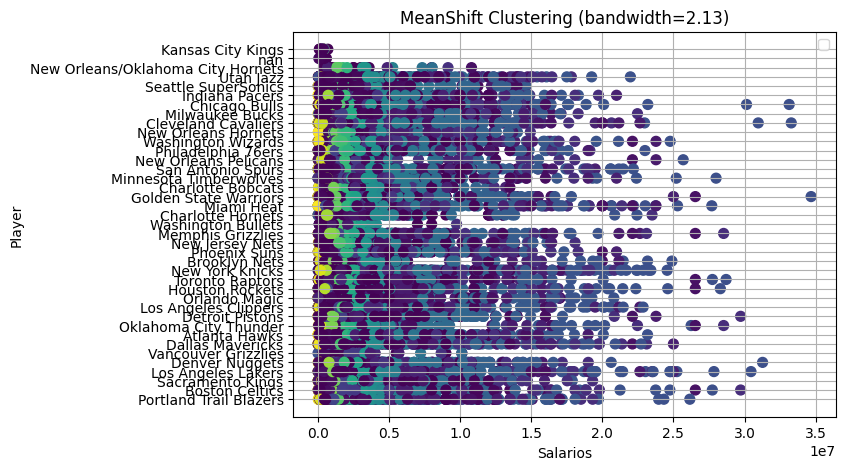

In [ ]:
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

# Aplicar MeanShift con bandwidth=2.13
bandwidth = 2.13

# Reshape la columna 'salary' para convertirla en un array 2D
salary_2d = df_salarios['salary'].values.reshape(-1, 1)

# Aplicar MeanShift
ms = MeanShift(bandwidth=bandwidth).fit(salary_2d)
labels = ms.labels_

# Convertir 'team' a cadenas
df_salarios['team'] = df_salarios['team'].astype(str)

# Convertir labels a enteros
labels = labels.astype(int)

# Graficar los resultados
plt.figure(figsize=(7, 5))
plt.scatter(df_salarios['salary'], df_salarios['team'], c=labels, s=50, cmap='viridis')
plt.title(f'MeanShift Clustering (bandwidth={bandwidth})')
plt.xlabel("Salarios")
plt.ylabel("Player")
plt.legend()
plt.grid(True)
plt.show()



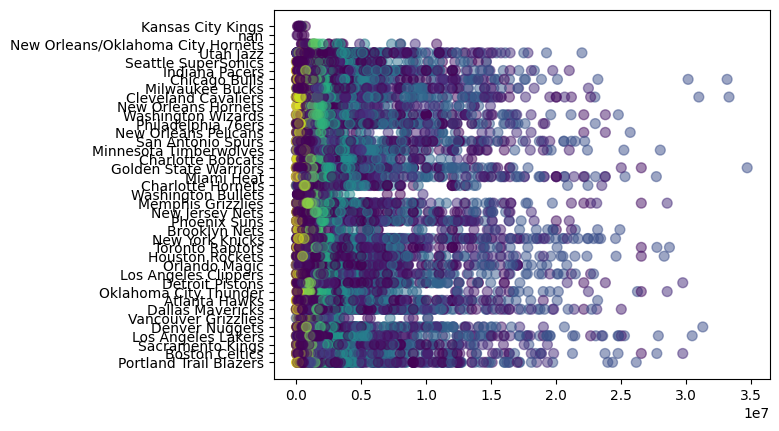

In [ ]:
plt.scatter(df_salarios['salary'], df_salarios['team'], c=labels, s=50, cmap='viridis', alpha=0.5)
